Generate binary ice masks for each glacier each year, by using the annual snow/ice percent data

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
from skimage.filters import threshold_otsu

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025") \
            .sort_values('o2region', ascending=False)

In [4]:
# function to get otsu threshold from a single year's data
# values less than or equal to min_bound will be removed prior to calculating
def get_otsu_thresh(im, min_bound=-1):
    
    # remove nans from data. optionally remove 0s if min_bound is set to 0
    all_values = im.values.flatten()
    all_values = all_values[~np.isnan(all_values)]
    all_values = all_values[all_values>min_bound]
    
    # calculate otsu thresh if we have any data
    if len(all_values)>1:
        calculated_t = threshold_otsu(image=all_values)
    else:
        calculated_t = -9999
    
    return calculated_t

In [5]:
# process each glacier
gdf_to_use = rgi_gdf

# subset to just a single glacier for testing
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-14-11612'] # baltoro
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-08331'] # khumbu
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-06794'] # ama dablam
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-05762'] # no water expected
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-09530'] # proglacial development
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-09532'] # complex proglacial, lots of icebergs
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-05619'] # simple proglacial
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-06758'] # lhotse
# gdf_to_use = rgi_gdf[rgi_gdf['rgi_id']=='RGI2000-v7.0-G-15-06763'] # imja

c=0
for idx, row in gdf_to_use.iterrows():
    c+=1
    # if c>1: continue

    # grab glacier regions, rgiid, area
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # if o1region!='15': continue
    # if rgi_id != "RGI2000-v7.0-G-14-11612": continue
    # print(c, "of", len(rgi_gdf), rgi_id)
    
    # print progress
    if c%10==1: print(c, "of", len(rgi_gdf), rgi_id)
    
    # open glacier mask, debris mask
    # path_open = os.path.join(folder_glaciers, rgi_id, 'glacier_mask.tif')
    # xr_gmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    # xr_gmask = xr_gmask.where(xr_gmask==1)
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_mask.tif')
    xr_dmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    xr_dmask = xr_dmask.where(xr_dmask==1, np.nan)
    
    ### we'll allow this to happen later down to road, to preserve flexibility
    # open glacier distances
    # path_open = os.path.join(folder_glaciers, rgi_id, 'debris_distances.tif')
    # xr_distance = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    # half_distance = np.nanmax(xr_distance)/2

    # open snice frequency data, mask to debris
    path_open = os.path.join(folder_glaciers, rgi_id, 'SnowIce', 'glacier_snice_frequency_acca.tif')
    xr_freq = riox.open_rasterio(path_open, masked=False,
                                 chunks={'band':'auto'}).astype(float)
    
    # rename bands to the years which they represent
    xr_freq = xr_freq.rename({"band":"year"})
    xr_freq['year'] = [int(i) for i in list(xr_freq.long_name)]
    xr_freq_mask = xr_freq*xr_dmask
    
    ### also open the usable data count info
    path_open = os.path.join(folder_glaciers, rgi_id, 'Usable', 'glacier_usable_count_acca.tif')
    xr_usable = riox.open_rasterio(path_open, masked=False,
                                   chunks={'band':'auto'}).astype(float)
    xr_usable = xr_usable.rename({"band":"year"})
    xr_usable['year'] = [int(i) for i in list(xr_usable.long_name)]
    xr_usable = xr_usable*xr_dmask
    
    ### apply masking on the annual water frequency timeseries
    # we may want to mask out pixels that have very small numbers of usable obs in a given year
    # xr_freq_mask = xr_freq_mask.where(xr_usable>3, np.nan)
    
    # or mask out pixels where water frequency very small
    # xr_freq_mask = xr_freq_mask.where(xr_freq>0.1, 0)
    
    # xr_freq_mask = xr_freq_mask.where(xr_distance>half_distance, 0)
    xr_freq_mask = xr_freq_mask.where(xr_dmask==1, np.nan)
    
    # list to store data
    all_binaries = []
    
    for y in range(1988,2024):
    # for y in xr_freq_mask['year']:
        # if y>1995: continue
        # get annual snice frequency from the past 5 years
        ymin = max(1988,y-5)
        ymax = max(y,ymin+5)
        
        # grab these years' data, average snice frequency across the 5 years
        freq_avg = xr_freq_mask.sel(year=slice(ymin,ymax)).mean(dim='year')
        
        # if frequency >0.6, call it ice
        binary_y = xr.where(freq_avg>=0.6, 1, 0)
        binary_y = binary_y.where(~np.isnan(xr_dmask), np.nan)
        binary_y['year'] = str(y)
        
        # save to list
        all_binaries.append(binary_y)
    
    # concat into dataset
    xr_binary = xr.concat(all_binaries, dim='year')
    
    # encode nan as 255 (so we can save as uint8)
    xr_binary = xr_binary.fillna(255).astype('uint8')
    xr_binary = xr_binary.assign_attrs(nodata=255)
    
    # save to folder
    out_path = os.path.join(folder_glaciers, rgi_id, 'SnowIce', 'debris_snice_binary_acca.tif')
    xr_binary.to_dataset(dim='year').rio.to_raster(out_path, compress='LZW', tiled=True)
    
print("All done!")

1 of 769 RGI2000-v7.0-G-15-18123
11 of 769 RGI2000-v7.0-G-15-14680
21 of 769 RGI2000-v7.0-G-15-18022
31 of 769 RGI2000-v7.0-G-15-17010
41 of 769 RGI2000-v7.0-G-15-07551
51 of 769 RGI2000-v7.0-G-15-07902
61 of 769 RGI2000-v7.0-G-15-08295
71 of 769 RGI2000-v7.0-G-15-06174
81 of 769 RGI2000-v7.0-G-15-08331
91 of 769 RGI2000-v7.0-G-15-06797
101 of 769 RGI2000-v7.0-G-15-09528
111 of 769 RGI2000-v7.0-G-15-09893
121 of 769 RGI2000-v7.0-G-15-11159
131 of 769 RGI2000-v7.0-G-15-08804
141 of 769 RGI2000-v7.0-G-15-08688
151 of 769 RGI2000-v7.0-G-15-09257
161 of 769 RGI2000-v7.0-G-15-01666
171 of 769 RGI2000-v7.0-G-15-01448
181 of 769 RGI2000-v7.0-G-15-01313
191 of 769 RGI2000-v7.0-G-15-01905
201 of 769 RGI2000-v7.0-G-15-00665
211 of 769 RGI2000-v7.0-G-15-00434
221 of 769 RGI2000-v7.0-G-15-00711
231 of 769 RGI2000-v7.0-G-15-00982
241 of 769 RGI2000-v7.0-G-15-02276
251 of 769 RGI2000-v7.0-G-15-05124
261 of 769 RGI2000-v7.0-G-15-05421
271 of 769 RGI2000-v7.0-G-15-02282
281 of 769 RGI2000-v7.0-G-15-05

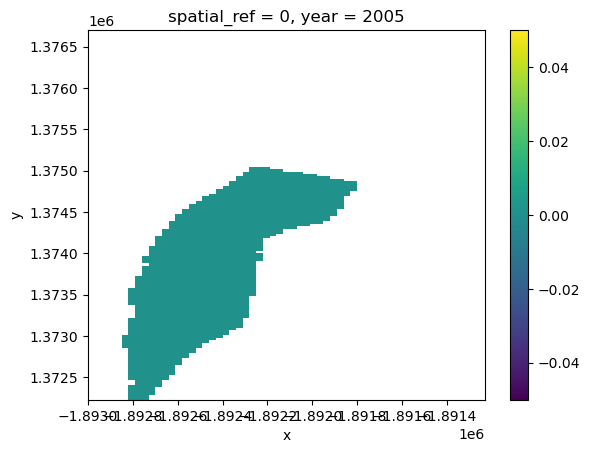

In [6]:
# grab a single year to plot
temp = xr_binary.where(xr_binary<200, np.nan)
temp.sel(year='2005').plot()

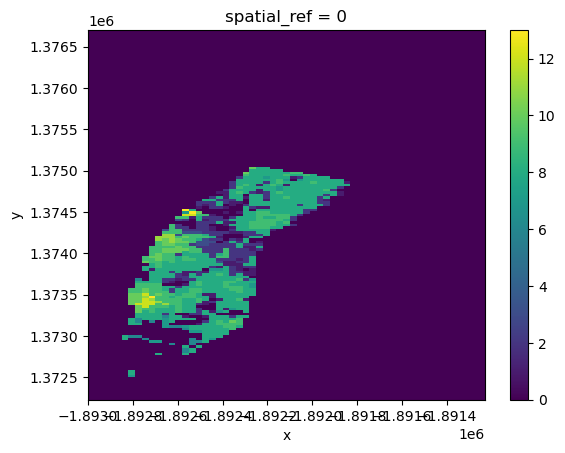

In [7]:
# plot average throughout the year
temp.sum(dim='year').plot()